# <font color='BLUE'> DAB400 - FINAL PROJECT - Predict Sales Using Time-series Models </font>

## <font color='BLUE'>GROUP NUMBER: 3 </font>

• Sowjanya Chilluveru: 0755566  
• Sriram bonasu: 0756345  
• Arwinder Kaur: 0746789  
• Gurpreet Kaur: 0756462  
• Trang Bui: 0753523  


## <font color='BLUE'>   Dataset Description </font>
- We use time-series data from the file “DataCoSupplyChainDataset.csv” in the website:  https://data.mendeley.com/datasets/8gx2fvg2k6/5   
- Data is gathered and provided by the company DataCo Global. The dataset file is introduced under a Creative Common Attribution 4.0 International license.  
- Data file contains information of sales, customer, order, product, shipping that related to supply chain business.  
- In this study, we extracted sales time-series data in 3-years period from Jan-2015 to Jan-2018 for sales forecasting analysis purpose. The sale data is processed by month including 37 data rows of monthly sales amount.  


## <font color='BLUE'>  Contribution  </font>
- Trang Bui: Looking for Dataset + Data Pre-processing & Exploration, ARIMA, LSTM models + coding combination and do final conclusion
- Gurpreet: MA model
- Arwinder: Exponential Smoothing (SES, DES, TES) model
- Sowjanja: ML models
- Sriram: ML models  
  
 

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import time
import os, sys    
from datetime import datetime, date

from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import math
from math import sqrt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## <font color='BLUE'> Load data and Data pre-processing </font>

In [2]:
def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 100):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['nb of unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] =  df.T.apply(lambda x: x.unique(), axis=1)
        return info.sort_values('data type')
    

# Load the dataset
data_folder = '' #'./data/'
file_name = 'DataCoSupplyChainDataset.csv'
df_orig = pd.DataFrame()
df_orig = pd.read_csv(data_folder + file_name) #, index_col ='order date (DateOrders)', parse_dates =True)
print('df_orig.shape',df_orig.shape)
df_orig.head(3)


df_orig.shape (180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.25,314.64,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.09,311.36,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.78,309.72,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


In [3]:
sniff_modified(df_orig)

,data type,percent missing,nb of unique,unique values
Product Card Id,int64,0.00,118,"[1360, 365, 627, 502, 278, 249, 191, 917, 828,..."
Order Item Cardprod Id,int64,0.00,118,"[1360, 365, 627, 502, 278, 249, 191, 917, 828,..."
Department Id,int64,0.00,11,"[2, 4, 5, 3, 6, 7, 10, 8, 9, 11, 12]"
Order Customer Id,int64,0.00,20652,"[20755, 19492, 19491, 19490, 19489, 19488, 194..."
Customer Id,int64,0.00,20652,"[20755, 19492, 19491, 19490, 19489, 19488, 194..."
Product Category Id,int64,0.00,51,"[73, 17, 29, 24, 13, 12, 9, 41, 37, 38, 44, 3,..."
Order Item Id,int64,0.00,180519,"[180517, 179254, 179253, 179252, 179251, 17925..."
Order Id,int64,0.00,65752,"[77202, 75939, 75938, 75937, 75936, 75935, 759..."
Late_delivery_risk,int64,0.00,2,"[0, 1]"
Product Status,int64,0.00,1,[0]


In [4]:
df_final_result=pd.DataFrame()
df = pd.DataFrame()
df[['order_month','sales']] = df_orig[['order date (DateOrders)','Sales']]
df['order_month'] =  pd.to_datetime(df['order_month'])
df = df.set_index('order_month').groupby(pd.Grouper(freq='M'))['sales'].sum().reset_index()
df['order_month']  = df['order_month'].to_numpy().astype('datetime64[M]')

print('df.shape',df.shape)
df.head(3)

df.shape (37, 2)


,order_month,sales
0,2015-01-01,1051590.08
1,2015-02-01,927009.90
2,2015-03-01,1051253.69


In [5]:
df.to_csv(data_folder + 'sales_data_after_preprocessing.csv', index = False)
sniff_modified(df)

,data type,percent missing,nb of unique,unique values
order_month,datetime64[ns],0.00,37,"[2015-01-01 00:00:00, 2015-02-01 00:00:00, 201..."
sales,float64,0.00,37,"[1051590.0801973597, 927009.8981680387, 105125..."


## <font color='BLUE'>  Data Exploration </font>

In [6]:
df = pd.read_csv(data_folder + 'sales_data_after_preprocessing.csv', index_col ='order_month', parse_dates =True)

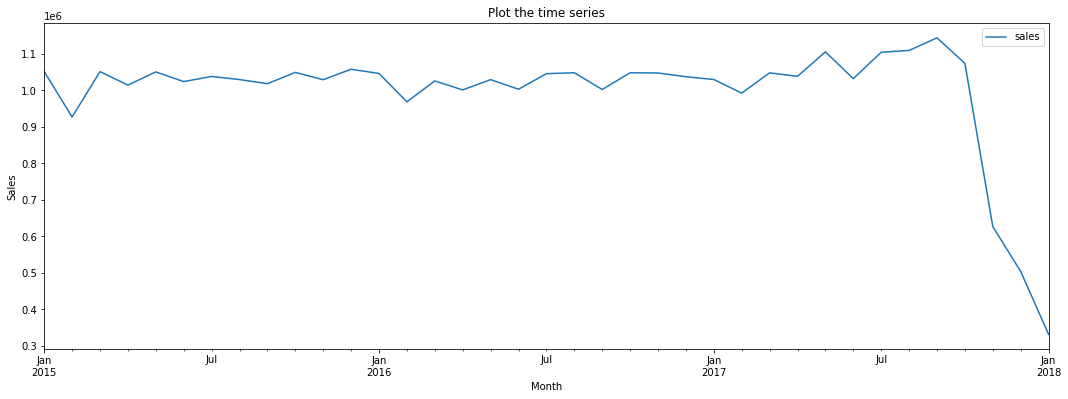

In [7]:
def fn_plottimeseries(df):
    df.plot(figsize=(18, 6))
    plt.title('Plot the time series')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

fn_plottimeseries(df)

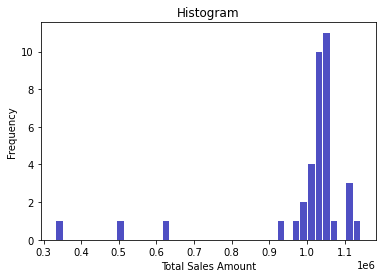

In [8]:
def display_histogram(X):
    plt.hist(x=X, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.xlabel('Total Sales Amount')
    plt.ylabel('Frequency')
    plt.title('Histogram')

display_histogram(df["sales"])

In [9]:
df[df.sales<700000]

,sales
order_month,
2017-11-01,626914.38
2017-12-01,503910.82
2018-01-01,331650.12


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sales,37.00,994182.03,161149.66,331650.12,1014463.28,1037408.17,1049154.27,1143775.11


#### <font color='BLUE'>  Comments </font>
- The chart demonstrated the fluctuation of monthly sales amount in a perriod of 3-years from Jan-2015 to Jan-2018. It can be seen that the sale amount fluctuated in the range from 900,000 to 1,100,000, however, the total sales reduced abnormally that are below 700,000 in 3 last months of this period. This abnormal sales need to be investigated to find out the special cause.
  
- Detail of data distribution is shown in the histogram:  
    - Count: 37 data rows that correspond to 37 months of 3-year period
    - Mean: the average sale amount is 994,182  
    - STD (standard deviation) is 161,149. This number is not too much far from the mean value.  
    - Min: the min sale amount is 331,650 on Jan 2018 that is too low in compare with mean value.
    - Max: the max sale amount is 1,143,775   
    - 25%. 50%, 75% percentiles are 1014463, 1037408, and 1049154 respectively. These values are close to the mean value. This shows that data distributes densely in the range of 25th and 75th percentile. The number out of the percentile range is negligible. Hence, although the shape look left-skewed, but most of data get normal distribution.  

## <font color='BLUE'>  Decompose the time series </font>

DECOMPOSE THE TIME SERIES


<Figure size 432x288 with 0 Axes>

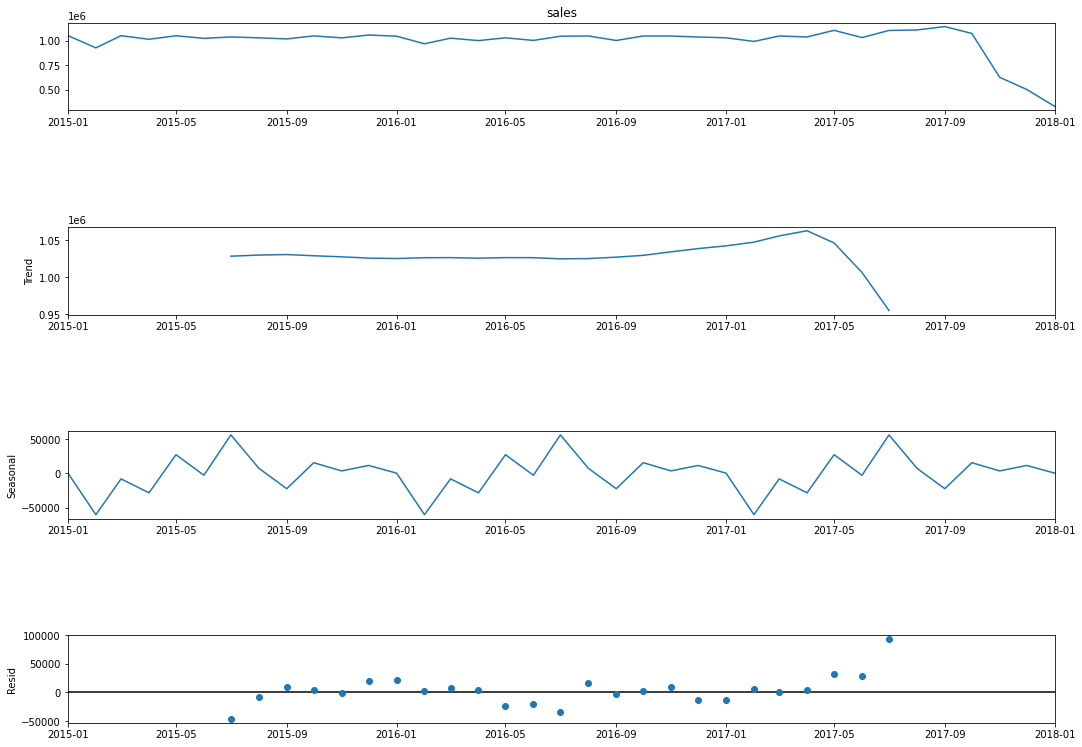

In [11]:
print('DECOMPOSE THE TIME SERIES')
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
# Decompose the time series
decomp = seasonal_decompose(df['sales'], freq=12)

# Plot decomposition
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(18, 12)

## <font color='BLUE'>  Comments </font>
- The first line graph expresses the sale amount that fluctuated in the range from 900,000 to 1,100,000 in the period of 3 year from Jan-2015 to Jan-2018, the total sales reduced abnormally below 700,000 in 3 last months of this period.  
- The trend graph shows that the sales are maintained stable during 3 years, but tended to go down rapidly from Nov-2017. 
- The seasonal graph indicated that the sales amount fluctuated repeatly by a cycle of 12 months.  
- Residual error is between [-50000, 50000].  


# <font color='RED'> ARIMA MODEL </font>

## Common functions

In [12]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_arima(df, p, d, q , P, D, Q, s):
    print('======================================================================================')
    print("(d, p, q)= (%s, %s, %s) " %(d,p,q))
    print("(D, P, Q, s) = (%s, %s, %s, %s)" %(D,P,Q,s))
    print('======================================================================================')
    # Instantiate the model   
    model = SARIMAX(df, order=(p,d,q), trend='c', seasonal_order=(P, D, Q, s))
    # Fit the model
    results = model.fit()
    # Print model fit summary
    print(results.summary())
    
    print('============================================')
    print('===== 4 diagostics plots for the model =====')
    print('============================================')
    fig = plt.figure()
    fig = results.plot_diagnostics()
    fig.set_size_inches(18, 8)
    return results

def plot_meanprediction(df,mean_forecast,confidence_intervals,ptitle):
    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:,'lower sales']
    upper_limits = confidence_intervals.loc[:,'upper sales']
    
    # plot the  data
    plt.plot(df.index, df, label='observed')

    # plot your mean predictions
    plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

    # shade the area between your confidence limits
    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
    
    print('Confidence intervals (pink band):')
    print(confidence_intervals)
    
    print('The best estimate predictions:')
    print(mean_forecast)

    # set labels, legends and show plot
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.title(ptitle)
    plt.show()
    return

#In-sample prediction and out-of-sample forecasting
def getprediction(df, results,nbstart,pdynamic,ptitle):
    # Generate predictions
    one_step_forecast = results.get_prediction(start=nbstart, dynamic=pdynamic)
    # Extract prediction mean
    mean_forecast = one_step_forecast.predicted_mean
    # Get confidence intervals of predictions
    confidence_intervals = one_step_forecast.conf_int()
    plot_meanprediction(df,mean_forecast, confidence_intervals,ptitle)
    return

# Out-of-sample forecasts
def getforecast(df,results,nbsteps,ptitle):
    forecast = results.get_forecast(steps =nbsteps)
    mean_forecast= forecast.predicted_mean
    confidence_intervals= forecast.conf_int()
    plot_meanprediction(df,mean_forecast, confidence_intervals,ptitle)
    return

## Start to build Time-Series Models
- p stands for the number of lag variables included in the ARIMA model, also called the lag order. (AR(p))  
- d stands for the number of times that the raw values in a time series dataset are differenced, also called the degree of differencing.  
- q denotes the magnitude of the moving average window, also called the order of moving average. (MA(q)) 

## 1. NON-seasonal ARIMA with parameters determined using ACF & PACF

### Check for Stationarity and determine d (d: differencing level)

In [13]:
# Perform Dickey Fuller Test, then make the series stationary if it is not
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(col):
    # Run Dicky-Fuller test
    adf_result = adfuller(df['sales'])
    # Print test statistic
    print('The result of the augmented Dicky-Fuller test')
    print(adf_result)
    print('\nADF (Argument Dickey Fuller): %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])

    if adf_result[1] <= 0.05:        
        print('\nCOMMENT: Data is stationary. Therefore, we can use ARIMA models to predict the next values of the time series with d=0')
    else:
        print('\nCOMMENT: Data is non-stationary. We cannot use ARIMA models. We have to transform non-stationary time series to stationary ones.')
    return

run_dicky_fuller(df['sales'])

The result of the augmented Dicky-Fuller test
(-3.9334580596875104, 0.0018019567638010378, 5, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 663.2506247798149)

ADF (Argument Dickey Fuller): -3.933458
p-value: 0.001802

COMMENT: Data is stationary. Therefore, we can use ARIMA models to predict the next values of the time series with d=0


In [14]:
d=0

### Determine p and q using ACF & PACF

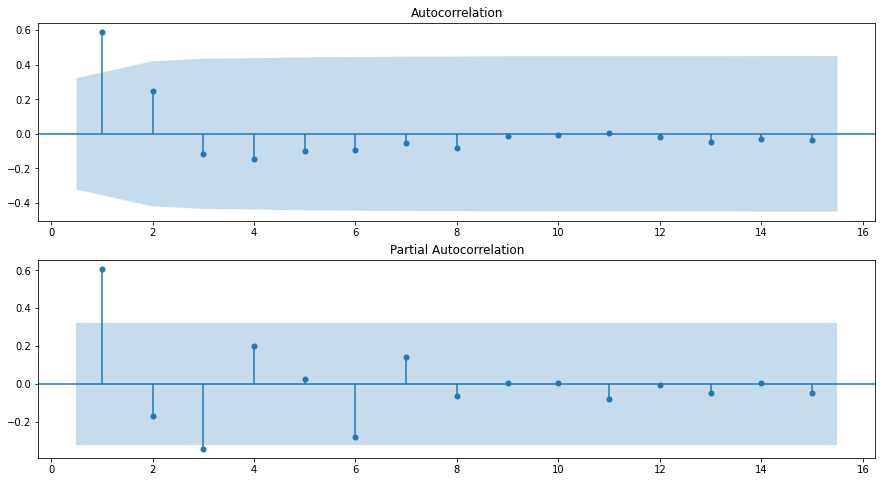

In [15]:
# Import ACF and PCF functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_corr(df, numberoflags):
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,8))
    # Plot the ACF on ax1
    plot_acf(df, lags=numberoflags, zero=False, ax=ax1)
    # Plot the PACF of on ax2
    plot_pacf(df, lags=numberoflags, zero=False, ax=ax2)
    plt.show()

plot_corr(df,15)

## <font color='BLUE'> Comment </font>
- ACF (MA) : The horizontal axis is the lag level, the vertical axis is the value of the correlation coefficient corresponding to the lag. The blue band is the 95% confidence interval for the correlation coefficient value to be zero. The correlation is out of the confidence interval, it is the most suitable latency that we should choose for the moving average (MA). Here, suitable q is at the lag #1  
- PACF (Partitial AutoCorrelation Function): compute the parameter p of the automatic regression (AR). It shows the value of the partial correlation coefficients corresponding to the different lag levels. The suitable values are outside the 95% confidence interval. Here, the lag of p = 1

## Generate non-seasonal arima model (d=0, p=1, q=1)

Generate non-seasonal model with parameters from ACF and PACF graphs
(d, p, q)= (0, 1, 1) 
(D, P, Q, s) = (0, 0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   37
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -561.467
Date:                Tue, 13 Apr 2021   AIC                           1130.934
Time:                        22:21:58   BIC                           1137.378
Sample:                    01-01-2015   HQIC                          1133.206
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.758e+05   7086.293    -24.811      0.000    -1.9e+05   -1.62e+05
ar.L1       

<Figure size 432x288 with 0 Axes>

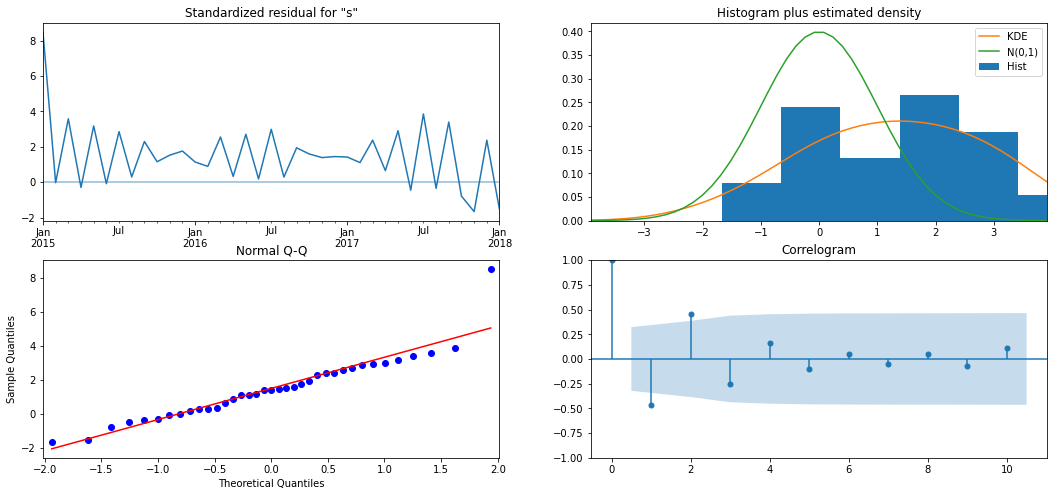

In [16]:
import warnings 
warnings.filterwarnings("ignore")
print('Generate non-seasonal model with parameters from ACF and PACF graphs')
p=1
q=1

P=0
D=0
Q=0
s=0
result1 = fit_arima(df,p,d,q,P,D,Q,s)

## 2. Determine p, q using the grid search and generate Non-seasonal ARIMA </font>

In [17]:
import warnings 
warnings.filterwarnings("ignore")
# Create empty list to store search results
result_aic_bic=[]
for p in range(3):
    for q in range(3):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = SARIMAX(df, order=(p,d,q), trend='c', freq=None)
            results = model.fit()
            # Append order and results tuple
            result_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print("p=",p, "q=",q, None, None)

# Construct DataFrame from result_aic_bic
df_aic_bic = pd.DataFrame(result_aic_bic,columns=['p', 'q', 'AIC', 'BIC'])

print('Order of increasing AIC')
print(df_aic_bic.sort_values('AIC'))

print('Order of increasing BIC')
print(df_aic_bic.sort_values('BIC'))

Order of increasing AIC
   p  q     AIC     BIC
5  1  2  958.72  966.78
2  0  2  960.68  967.12
8  2  2  974.89  984.56
1  0  1  979.20  984.04
0  0  0  995.25  998.48
7  2  1  998.70 1006.76
6  2  0 1007.88 1014.33
4  1  1 1130.93 1137.38
3  1  0 1337.68 1342.52
Order of increasing BIC
   p  q     AIC     BIC
5  1  2  958.72  966.78
2  0  2  960.68  967.12
1  0  1  979.20  984.04
8  2  2  974.89  984.56
0  0  0  995.25  998.48
7  2  1  998.70 1006.76
6  2  0 1007.88 1014.33
4  1  1 1130.93 1137.38
3  1  0 1337.68 1342.52


Generate non-seasonal model with parameters from Grid Search
p,q= 1 2
(d, p, q)= (0, 1, 2) 
(D, P, Q, s) = (0, 0, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   37
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -474.362
Date:                Tue, 13 Apr 2021   AIC                            958.724
Time:                        22:22:00   BIC                            966.778
Sample:                    01-01-2015   HQIC                           961.563
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.223e+05   1.03e+05      7.954      0.000     6.2e+05    1.02e+06
ar.L1      

<Figure size 432x288 with 0 Axes>

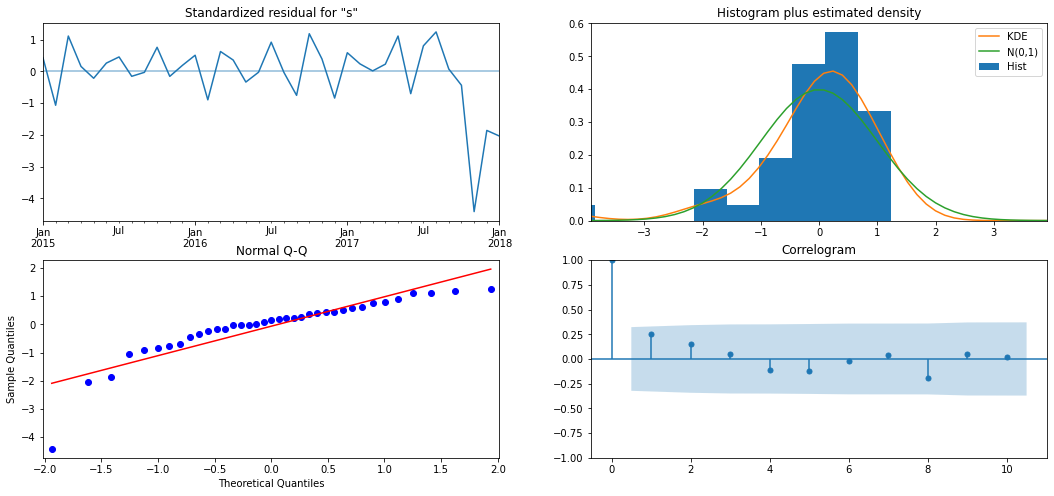

In [18]:
import warnings 
warnings.filterwarnings("ignore")
print("Generate non-seasonal model with parameters from Grid Search")

p = int(df_aic_bic.sort_values('AIC').iloc[0]['p'])
q = int(df_aic_bic.sort_values('AIC').iloc[0]['q'])
print('p,q=',p,q)
      
P=0
D=0
Q=0
s=0
results2 = fit_arima(df,p,d,q,P,D,Q,s)

## 3. Do seasonal forecast using "auto-arima" to get parameters </font>

In [19]:
#pip install pmdarima
import pmdarima as pm
import re

# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = pm.auto_arima(df, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, scoring='mse')
print(model_s.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=995.254, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1328.868, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=980.906, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1129.851, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=979.204, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=981.203, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=982.897, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1130.934, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=960.676, Time=0.09 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=962.676, Time=0.20 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=962.311, Time=0.10 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=964.308, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=958.724, Time=0.08 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=959.164, Time=0.35 sec
 ARIMA(1,0,2)(0,0,1)[12] inter

(d, p, q)= (0, 0, 3) 
(D, P, Q, s) = (0, 0, 0, 12)
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   37
Model:               SARIMAX(0, 0, 3)   Log Likelihood                -473.375
Date:                Tue, 13 Apr 2021   AIC                            956.750
Time:                        22:22:05   BIC                            964.805
Sample:                    01-01-2015   HQIC                           959.590
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.773e+05    6.9e+04     14.171      0.000    8.42e+05    1.11e+06
ma.L1          0.9826      0.228      4.303      0.000       0.535       1.430
m

<Figure size 432x288 with 0 Axes>

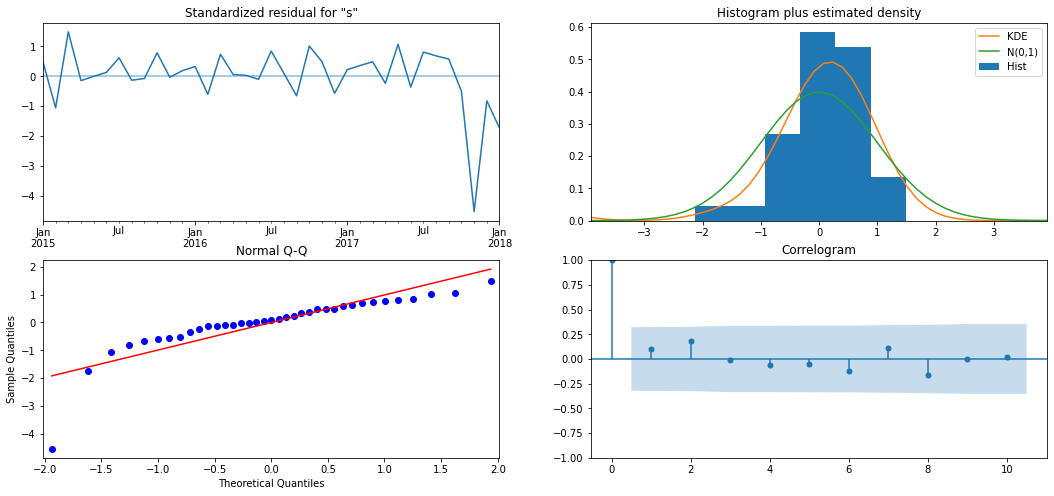

In [20]:
p=0
d=0
q=3

P=0
D=0
Q=0
s=12
results3 = fit_arima(df,p,d,q,P,D,Q,s)

## <font color='BLUE'> Comment </font>
- Based on P-value, AIC and BIC, we can conclude the seasonal SARIMA model is the best with the parameters (d, p, q)= (0, 0, 3) and (D, P, Q, s) = (0, 0, 0, 12) among three above models.
- With this time series data, the correlation ecoefficiency values are close to value 1, this shows the model is good fitting because of the strongn correlation ecoefficiency between independent variables and response variables.  
- Moreover, the correlgrams shows coefficient for regression  

Confidence intervals (pink band):
            lower sales  upper sales
2017-02-01    795263.41   1128854.19
2017-03-01    839921.87   1173495.81
2017-04-01    891733.53   1225247.67
2017-05-01    847861.40   1181326.91
2017-06-01    896067.91   1229523.49
2017-07-01    868770.90   1202174.31
2017-08-01    884520.92   1217923.78
2017-09-01    928102.11   1261473.34
2017-10-01    950335.71   1283696.56
2017-11-01    845587.94   1178938.85
2017-12-01    407133.89    740467.76
2018-01-01    312262.57    645595.96
The best estimate predictions:
2017-02-01    962058.80
2017-03-01   1006708.84
2017-04-01   1058490.60
2017-05-01   1014594.15
2017-06-01   1062795.70
2017-07-01   1035472.60
2017-08-01   1051222.35
2017-09-01   1094787.73
2017-10-01   1117016.13
2017-11-01   1012263.39
2017-12-01    573800.83
2018-01-01    478929.26
Freq: MS, Name: predicted_mean, dtype: float64


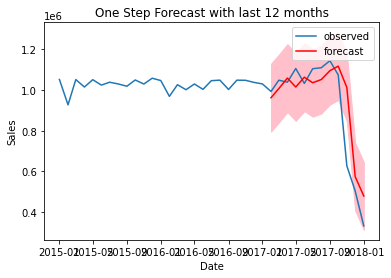

Confidence intervals (pink band):
            lower sales  upper sales
2017-02-01    795263.41   1128854.19
2017-03-01    742974.00   1210571.11
2017-04-01    691759.45   1279134.14
2017-05-01    675096.26   1279578.80
2017-06-01    675096.26   1279578.80
2017-07-01    675096.26   1279578.80
2017-08-01    675096.26   1279578.80
2017-09-01    675096.26   1279578.80
2017-10-01    675096.26   1279578.80
2017-11-01    675096.26   1279578.80
2017-12-01    675096.26   1279578.80
2018-01-01    675096.26   1279578.80
The best estimate predictions:
2017-02-01   962058.80
2017-03-01   976772.56
2017-04-01   985446.80
2017-05-01   977337.53
2017-06-01   977337.53
2017-07-01   977337.53
2017-08-01   977337.53
2017-09-01   977337.53
2017-10-01   977337.53
2017-11-01   977337.53
2017-12-01   977337.53
2018-01-01   977337.53
Freq: MS, Name: predicted_mean, dtype: float64


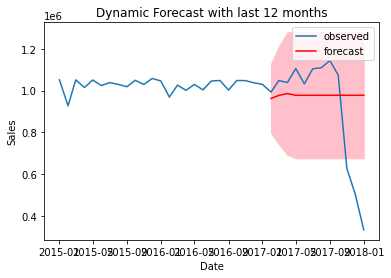

Confidence intervals (pink band):
            lower sales  upper sales
2018-02-01    426113.54    759432.99
2018-03-01    556507.93   1023804.69
2018-04-01    620504.49   1207838.16
2018-05-01    675096.26   1279578.80
2018-06-01    675096.26   1279578.80
2018-07-01    675096.26   1279578.80
2018-08-01    675096.26   1279578.80
2018-09-01    675096.26   1279578.80
2018-10-01    675096.26   1279578.80
2018-11-01    675096.26   1279578.80
2018-12-01    675096.26   1279578.80
2019-01-01    675096.26   1279578.80
2019-02-01    675096.26   1279578.80
2019-03-01    675096.26   1279578.80
2019-04-01    675096.26   1279578.80
2019-05-01    675096.26   1279578.80
2019-06-01    675096.26   1279578.80
2019-07-01    675096.26   1279578.80
2019-08-01    675096.26   1279578.80
2019-09-01    675096.26   1279578.80
2019-10-01    675096.26   1279578.80
2019-11-01    675096.26   1279578.80
2019-12-01    675096.26   1279578.80
2020-01-01    675096.26   1279578.80
The best estimate predictions:
2018-02-01

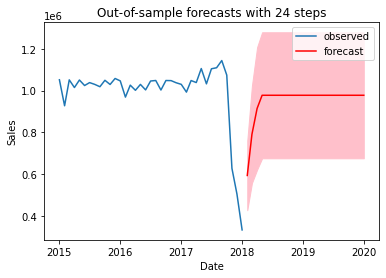

In [21]:
getprediction(df, results3,nbstart=-12,pdynamic=False,ptitle='One Step Forecast with last 12 months')
getprediction(df, results3,nbstart=-12,pdynamic=True,ptitle='Dynamic Forecast with last 12 months')
getforecast(df,results3,nbsteps=24,ptitle='Out-of-sample forecasts with 24 steps')

## <font color='BLUE'> Comment </font>
- The SARIMA model can well forecast with in sample data. But, it hardly forecasts the fluctuation of sales in next 12 period with out of sample data. However, the confidence interval range of sales amount (pink band) are focrcasted between the range [675,000 - 127,900]. In this case, in my opinion, more training data is expected so that the model can learn and do forecasting better

# <font color='RED'> LSTM Model </font>

### Common functions

In [22]:
def display_history(history):
    history.history.keys()
    history_dict = history.history # the dictionary that has the information on loss and accuracy per epoch
    
    loss_values = history_dict['loss']   # training loss
    val_loss_values = history_dict['val_loss'] # validation loss

    plt.plot(history.history['loss'], 'b', label="Training Loss")
    plt.plot(history.history['val_loss'], 'r', label="Test Loss")
    plt.title("Training and Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return

    
def plot_prediction(df, train_predict, test_predict, time_step):
    # shifting train    
    train_plot = np.empty_like(df) # create an array with the same shape as provided
    train_plot[:, :] = np.nan
    train_plot[time_step: len(train_predict)+time_step, :] = train_predict
    # shifting test predictions for plotting
    test_plot = np.empty_like(df)
    test_plot[:, :] = np.nan
    test_plot[len(train_predict)+(time_step*2)+1:len(df)-1, :] = test_predict
    # plot baseline and predictions
    plt.plot(scalar.inverse_transform(df))
    plt.plot(train_plot)
    plt.plot(test_plot)
    plt.show()
    
# Make predictions
def do_prediction(model, train_X, test_X, train_Y, test_Y, df, scalar, time_step):
    train_Y_predict = model.predict(train_X)
    test_Y_predict = model.predict(test_X)
    
    # inverting predictions
    train_Y_predict = scalar.inverse_transform(train_Y_predict)
    train_Y = scalar.inverse_transform([train_Y])
    test_Y_predict = scalar.inverse_transform(test_Y_predict)
    test_Y = scalar.inverse_transform([test_Y])
    
    # calculate root mean squared error
    train_score = math.sqrt(mean_squared_error(train_Y[0], train_Y_predict[:,0]))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(test_Y[0], test_Y_predict[:,0]))
    print('Test Score: %.2f RMSE' % (test_score))

    
    MAE_train=np.mean(abs(train_Y- train_Y_predict))/np.mean(train_Y)     
    MAE_test=np.mean(abs(test_Y-test_Y_predict))/np.mean(test_Y)
   
    
    result={'train RMSE score':train_score,'test RMSE score':test_score, 'MAE train':MAE_train,'MAE test':MAE_test}
   
    plot_prediction(df, train_Y_predict, test_Y_predict, time_step)
        
    return result
#     return result,train_Y_predict, test_Y_predict

In [23]:
df_sales = pd.read_csv(data_folder + 'sales_data_after_preprocessing.csv')
print('df_lstm.shape:', df_sales.shape)
df_sales.head()


df_lstm.shape: (37, 2)


,order_month,sales
0,2015-01-01,1051590.08
1,2015-02-01,927009.90
2,2015-03-01,1051253.69
3,2015-04-01,1014463.28
4,2015-05-01,1050478.44


In [24]:
# med_value = df_sales['sales'].median()
# print('median (50th percentile):',med_value)
# df[df.sales<700000]

In [25]:
# df_sales.loc[df_sales['sales'] <700000, 'sales'] = med_value
# display_histogram(df_sales["sales"])
# df_sales.describe().transpose()

In [26]:
df_lstm = df_sales.iloc[:,1].values
df_lstm

array([1051590.08019736,  927009.89816804, 1051253.69033427,
       1014463.27982258, 1050478.44015248, 1024006.16983203,
       1038081.19009587, 1029494.69063876, 1018338.59997453,
       1049154.27043329, 1029120.24061873, 1057840.8806148 ,
       1046308.25050021,  968542.84902541, 1025853.12081797,
       1001211.57977836, 1029400.20072332, 1003059.550005  ,
       1045715.62086199, 1048200.25111361, 1002397.03993801,
       1048130.5504065 , 1047590.14107461, 1037408.170125  ,
       1029698.02014772,  992534.89879035, 1048004.78106534,
       1038321.62087005, 1105485.32189608, 1032086.49031081,
       1104373.36097924, 1109337.17125681, 1143775.10762318,
       1073994.16902057,  626914.38366699,  503910.81734302,
        331650.11515684])

In [27]:
df_lstm = df_lstm.reshape(-1,1)
df_lstm = df_lstm.astype('float32')
print('df_lstm.dtype',df_lstm.dtype)
print('df_lstm.shape',df_lstm.shape)
#df_lstm

df_lstm.dtype float32
df_lstm.shape (37, 1)


In [28]:
# Scaling the data
scalar =MinMaxScaler(feature_range=(0,1))
df_lstm =scalar.fit_transform(df_lstm)
#df_lstm

In [29]:
# Split into train and test
train = df_lstm[:-12,:]
test = df_lstm[-12:,:]
print('len(train):',len(train))
print('len(test):',len(test))
# train

len(train): 25
len(test): 12


In [30]:
# Building the 2D array for supervised learning
def create_data(sequence, time_step, nb_predict):
    dataX = []
    dataY = []
    nloop = len(sequence)-time_step-nb_predict
    for i in range(nloop):
        a = sequence[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(sequence[i + time_step, 0])
    return np.array(dataX),  np.array(dataY)

In [31]:
time_step = 1  # input [time_step] values to predict [nb_predict] value
nb_predict = 1

# Apply the 2D array function to train and test datasets
train_X, train_Y = create_data(train,time_step, nb_predict)
test_X, test_Y = create_data(test, time_step, nb_predict)
print('len train_X',len(train_X))
print('len train_Y',len(train_Y))
print('len test_X',len(test_X))
print('len test_Y',len(test_Y))
print('train_X.shape',train_X.shape)
print('train_Y.shape',train_Y.shape)
print('test_X.shape',test_X.shape)
print('test_Y.shape',test_Y.shape)

len train_X 23
len train_Y 23
len test_X 10
len test_Y 10
train_X.shape (23, 1)
train_Y.shape (23,)
test_X.shape (10, 1)
test_Y.shape (10,)


In [32]:
#train_X

In [33]:
#train_Y

In [34]:
# train_Y_temp = train_Y.reshape(-1,1)
# df_temp=np.concatenate((train_X,train_Y_temp),axis=1)
# df_temp

In [35]:
# transform input from [samples, features] to [samples, timesteps, features] basically from 2D to 3D
nb_samples = train_X.shape[0]
nb_features = train_X.shape[1]
train_X = np.reshape(train_X, (nb_samples, time_step, nb_features))

nb_samples = test_X.shape[0]
nb_features = test_X.shape[1]
test_X = np.reshape(test_X, (nb_samples, time_step, nb_features))

### Build the simple LSTM model

BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 5


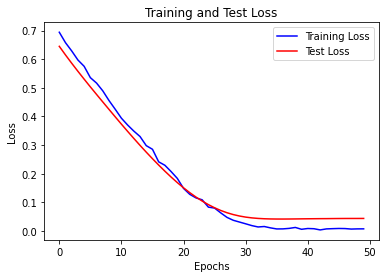

Train Score: 39360.16 RMSE
Test Score: 170338.55 RMSE


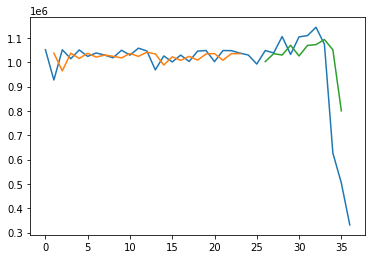

BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


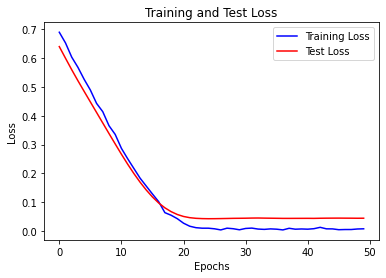

Train Score: 39419.06 RMSE
Test Score: 170723.16 RMSE


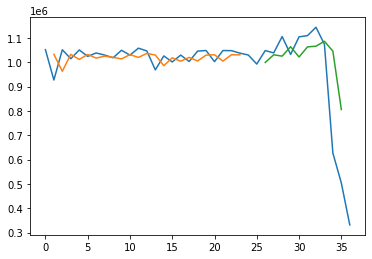

BUILD LSTM MODEL============================================================================================
----------Optimizer: rmsprop
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


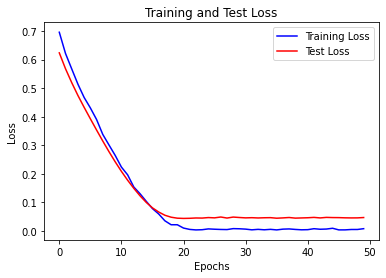

Train Score: 37471.50 RMSE
Test Score: 175782.66 RMSE


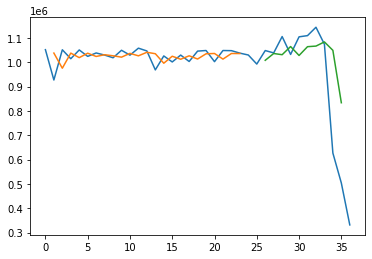

BUILD LSTM MODEL============================================================================================
----------Optimizer: sgd
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 3


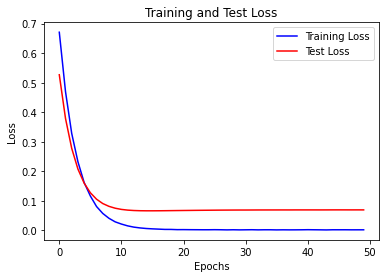

Train Score: 29953.49 RMSE
Test Score: 213175.55 RMSE


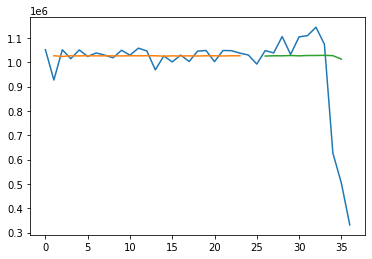

In [36]:
from collections import OrderedDict


def fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle):
    print('BUILD LSTM MODEL============================================================================================')
    print('----------Optimizer:', p_optimizer)
    print('----------Activation: ',p_activation)
    print('----------Input shape: ', p_input_shape)
    print('----------Loss: ',p_loss) 
    print('----------Number of p_epochs:',p_epochs)
    print('----------Batch Size',p_batch_size)
    start_time = time.time() 
    
    model = Sequential()
    # Adding the input layer and LSTM layer
    model.add(LSTM(units=50, activation= p_activation, input_shape =p_input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer =p_optimizer, loss=p_loss,metrics=['acc'])
        
    history = model.fit(train_X, train_Y, batch_size=p_batch_size, epochs =p_epochs, validation_data=(test_X, test_Y), verbose=p_verbose,shuffle=p_shuffle)
    training_duration = time.time() - start_time
    display_history(history)
    
    result = do_prediction(model, train_X, test_X, train_Y, test_Y, df_lstm, scalar, time_step)
    
    info={'Optimizer':p_optimizer, 'Activation':p_activation,'Loss':p_loss,'Nb Epochs':p_epochs,'Input shape':p_input_shape,'Batch size':p_batch_size,'Training Duration':training_duration}
    result_info = dict(info)    
    result_info.update(result)
    
    return result_info, model



df_score = pd.DataFrame()

p_optimizer='adam'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 5
p_epochs=50
p_verbose=0
p_shuffle=False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='adam'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='rmsprop'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=True
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

p_optimizer='sgd'
p_input_shape = (train_X.shape[1], train_X.shape[2]) #(1, time_sttime_stepep_back)
p_loss = 'mse'
p_activation='relu'
p_batch_size = 3
p_epochs=50
p_verbose=0
p_shuffle=True
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
df_score=df_score.append(OrderedDict(result_info),ignore_index=True)


In [37]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_score.sort_values(by=['test RMSE score','MAE test', 'train RMSE score','test RMSE score'], inplace=True, ascending=True)
df_score

,Activation,Batch size,Input shape,Loss,MAE test,MAE train,Nb Epochs,Optimizer,Training Duration,test RMSE score,train RMSE score
0,relu,5.00,"(1, 1)",mse,0.15,0.03,50.00,adam,6.12,170338.55,39360.16
1,relu,3.00,"(1, 1)",mse,0.15,0.03,50.00,adam,4.59,170723.16,39419.06
2,relu,3.00,"(1, 1)",mse,0.15,0.02,50.00,rmsprop,4.66,175782.66,37471.50
3,relu,3.00,"(1, 1)",mse,0.14,0.02,50.00,sgd,4.15,213175.55,29953.49


## <font color='GREEN'>  Use the best LSTM model to forecast next 12-months period </font>

The best LSTM model in this work with below parameters: 
BUILD LSTM MODEL============================================================================================
----------Optimizer: adam
----------Activation:  relu
----------Input shape:  (1, 1)
----------Loss:  mse
----------Number of p_epochs: 50
----------Batch Size 5


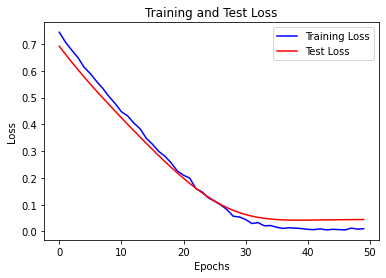

Train Score: 39116.72 RMSE
Test Score: 171367.11 RMSE


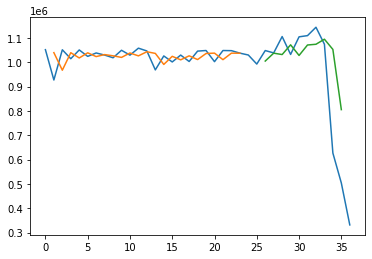

FORECAST NEXT 12-MONTHS PERIOD USING THE BEST LSTM MODEL


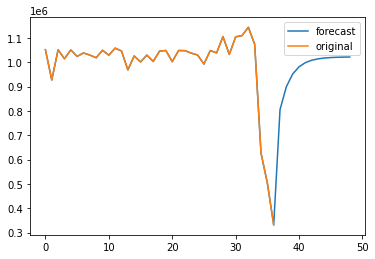

In [38]:
def forecast(model, train_X, test_X, train_Y, test_Y, n_period = 12, time_step=1):
    x = test_X[-1]
    preds = []
    for i in range(n_period):
        data = np.expand_dims(x, axis=0)
        prediction = model.predict(data)
        preds.append([prediction[0][0]])
        x = np.delete(x, 0, axis=0) # delete first row
        x = np.vstack([x, prediction]) # add prediction
    return preds

def plot_forecast(df,df_forecast12):
    df_forecast12=scalar.inverse_transform(df_forecast12)
    df=scalar.inverse_transform(df)
    plt.plot(df_forecast12,label='forecast')
    plt.plot(df,label='original')
    plt.legend()
    plt.show()

print('============================================================================================================')
print('The best LSTM model in this work with below parameters: ')
p_optimizer= df_score.iloc[0]['Optimizer'] 
p_input_shape = df_score.iloc[0]['Input shape'] 
p_loss = df_score.iloc[0]['Loss'] 
p_activation= df_score.iloc[0]['Activation'] 
p_batch_size = int(df_score.iloc[0]['Batch size']) 
p_epochs= int(df_score.iloc[0]['Nb Epochs']) 
p_verbose=0
p_shuffle= False
result_info,model = fit_lstm(p_optimizer, p_activation, p_input_shape, p_loss, train_X, train_Y, test_X, test_Y, p_batch_size, p_epochs, p_verbose, p_shuffle)
# df_score=df_score.append(OrderedDict(result_info),ignore_index=True)

final_result = {'Model': 'LSTM', 'MAE Train': result_info['MAE train'], 'MAE Test':result_info['MAE test']}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)


print('FORECAST NEXT 12-MONTHS PERIOD USING THE BEST LSTM MODEL')
n_period = 12
time_step=1
df_preds = forecast(model,train_X, test_X, train_Y, test_Y, n_period, time_step)      
df_forecast12=np.append(df_lstm,df_preds).reshape(-1,1)
plot_forecast(df_lstm,df_forecast12)

# <font color='RED'> Moving Average </font>

In [39]:
df = pd.read_csv(data_folder + 'sales_data_after_preprocessing.csv', index_col ='order_month', parse_dates =True)
print(df.shape)
df.head()

(37, 1)


,sales
order_month,
2015-01-01,1051590.08
2015-02-01,927009.90
2015-03-01,1051253.69
2015-04-01,1014463.28
2015-05-01,1050478.44


In [40]:
train=df[0:-12] 
test=df[-12:]
print(train.shape)
print(test.shape)

(25, 1)
(12, 1)


In [41]:
df['MA_12'] = df.sales.rolling(12,min_periods=1).mean()

In [42]:
df.head()

,sales,MA_12
order_month,,
2015-01-01,1051590.08,1051590.08
2015-02-01,927009.90,989299.99
2015-03-01,1051253.69,1009951.22
2015-04-01,1014463.28,1011079.24
2015-05-01,1050478.44,1018959.08


In [43]:
mae = metrics.mean_absolute_error(df['sales'], df['MA_12'])
mse = metrics.mean_squared_error(df['sales'], df['MA_12'])
rmse = np.sqrt(mse)  

final_result = {'Model': 'MA', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

print('MAE = ',round(mae,2))
print('MSE = ',round(mse,2))
print('RMSE = ',round(rmse,2))

MAE =  62513.0
MSE =  21124506200.28
RMSE =  145342.72


In [44]:
df.head()

,sales,MA_12
order_month,,
2015-01-01,1051590.08,1051590.08
2015-02-01,927009.90,989299.99
2015-03-01,1051253.69,1009951.22
2015-04-01,1014463.28,1011079.24
2015-05-01,1050478.44,1018959.08


Text(0, 0.5, 'sales')

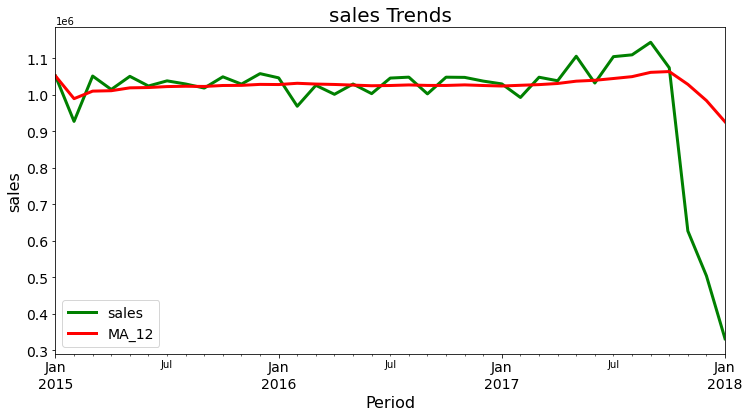

In [45]:
# colors for the line plot
colors = ['green', 'red','blue']

# line plot for sales
df.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['sales','MA_12' ], fontsize=14)

# title and labels
plt.title('sales Trends', fontsize=20)
plt.xlabel('Period', fontsize=16)
plt.ylabel('sales', fontsize=16)

## <font color='BLUE'> Comment </font>
- The length we have chosen for the MA is 12 weeks. We have also depicted a graph accordingly to the sales. The value obtained for MAE (Mean absolute error) is 62513.0 and MSE (Mean squared error) is 21124506200.28. The value obtained for RMSE (Root mean squared error) is 145342.72.  

# <font color='RED'> Exponential Smoothing (SES, DES, TES ) </font>

In [46]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt

df = pd.read_csv(data_folder + 'sales_data_after_preprocessing.csv', index_col ='order_month', parse_dates =True)
print(df.shape)
df.head()

(37, 1)


,sales
order_month,
2015-01-01,1051590.08
2015-02-01,927009.90
2015-03-01,1051253.69
2015-04-01,1014463.28
2015-05-01,1050478.44


In [47]:
train=df[0:-12] 
test=df[-12:]
print(train.shape)
print(test.shape)

(25, 1)
(12, 1)


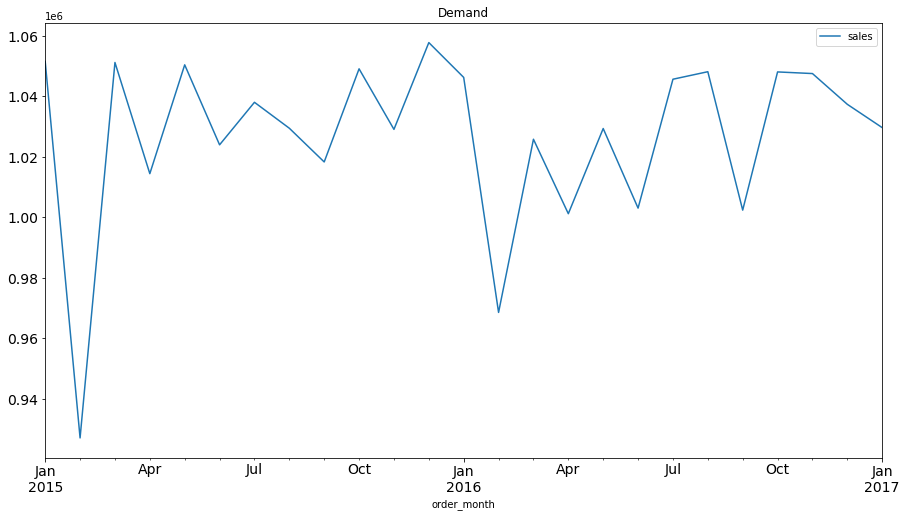

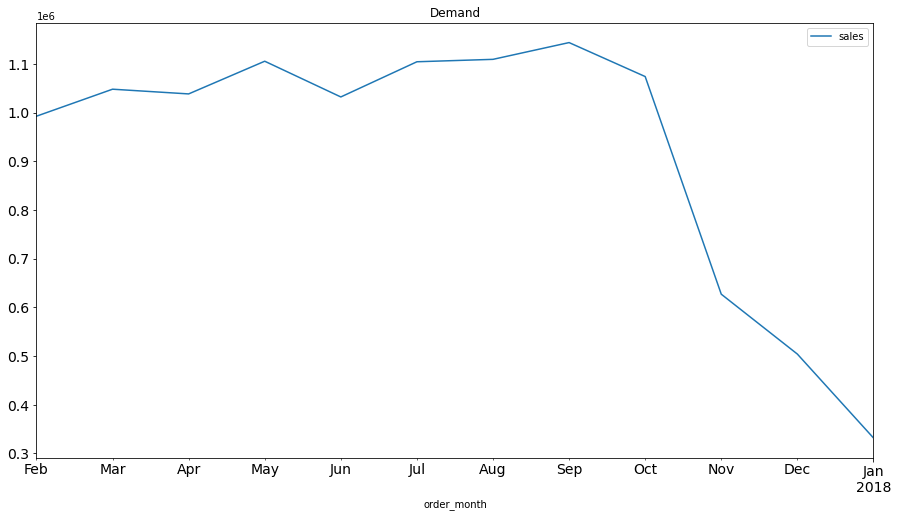

In [48]:
#Plotting train and test data
train.plot(figsize=(15,8), title= 'Demand', fontsize=14)
test.plot(figsize=(15,8), title= 'Demand', fontsize=14)
plt.show()

## Simple Exponential Smoothing

MAE 172,590.86
MSE 80,633,560,970.77
RMSE 283,960.49


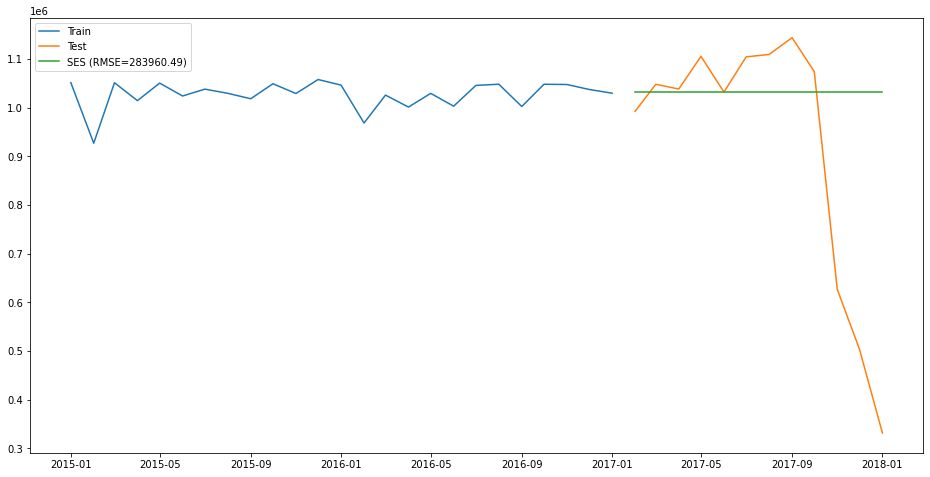

In [49]:
pred = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['sales'])).fit(smoothing_level=0.2,optimized=False)# alpha=0.2
pred['SES'] = fit2.forecast(len(test))
# Calculate KPI's
mae = mean_absolute_error(test.sales, pred.SES)
mse=mean_squared_error(test.sales, pred.SES)
rmse = sqrt(mean_squared_error(test.sales, pred.SES))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'SES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(pred['SES'], label='SES (RMSE={:.2f})'.format(rmse)) 
plt.legend()
plt.show()

In [50]:
pred

,sales,SES
order_month,,
2017-02-01,992534.90,1032552.26
2017-03-01,1048004.78,1032552.26
2017-04-01,1038321.62,1032552.26
2017-05-01,1105485.32,1032552.26
2017-06-01,1032086.49,1032552.26
2017-07-01,1104373.36,1032552.26
2017-08-01,1109337.17,1032552.26
2017-09-01,1143775.11,1032552.26
2017-10-01,1073994.17,1032552.26


## Double Exponential Smoothing (Holt)

MAE 173,160.57
MSE 91,534,248,632.85
RMSE 302,546.28


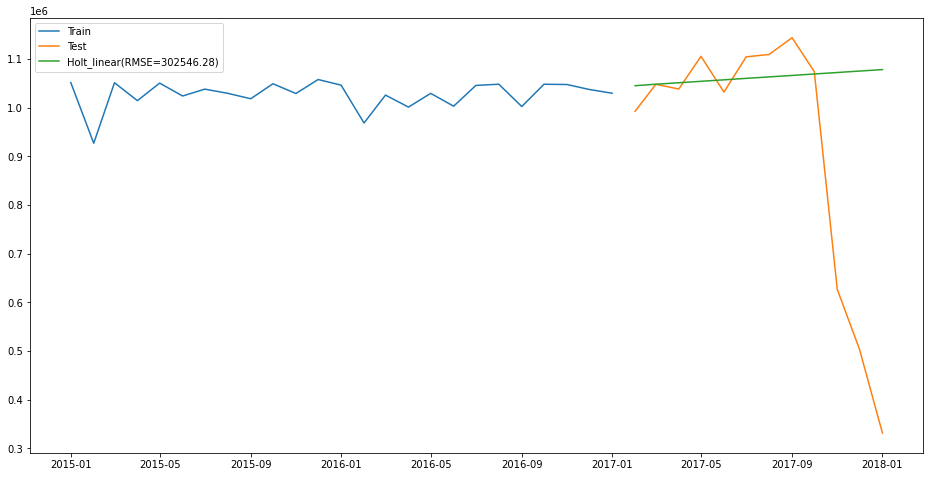

In [51]:
# Fit the model
pred = test.copy()
fit1 = Holt(np.asarray(train['sales'])).fit(smoothing_level = 0.3,smoothing_slope = 0.4)
pred['Holt_linear'] = fit1.forecast(len(test))
# Calculate KPI
mae = mean_absolute_error(test.sales, pred.Holt_linear)
mse=mean_squared_error(test.sales, pred.Holt_linear)
rmse = sqrt(mean_squared_error(test.sales, pred.Holt_linear))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'DES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(pred['Holt_linear'], label='Holt_linear(RMSE={:.2f})'.format(rmse))
plt.legend()
plt.show()

In [52]:
pred

,sales,Holt_linear
order_month,,
2017-02-01,992534.90,1045167.71
2017-03-01,1048004.78,1048173.89
2017-04-01,1038321.62,1051180.06
2017-05-01,1105485.32,1054186.23
2017-06-01,1032086.49,1057192.40
2017-07-01,1104373.36,1060198.57
2017-08-01,1109337.17,1063204.75
2017-09-01,1143775.11,1066210.92
2017-10-01,1073994.17,1069217.09


## Triple Exponential Smoothing

MAE 180,007.27
MSE 83,114,867,831.86
RMSE 288,296.49


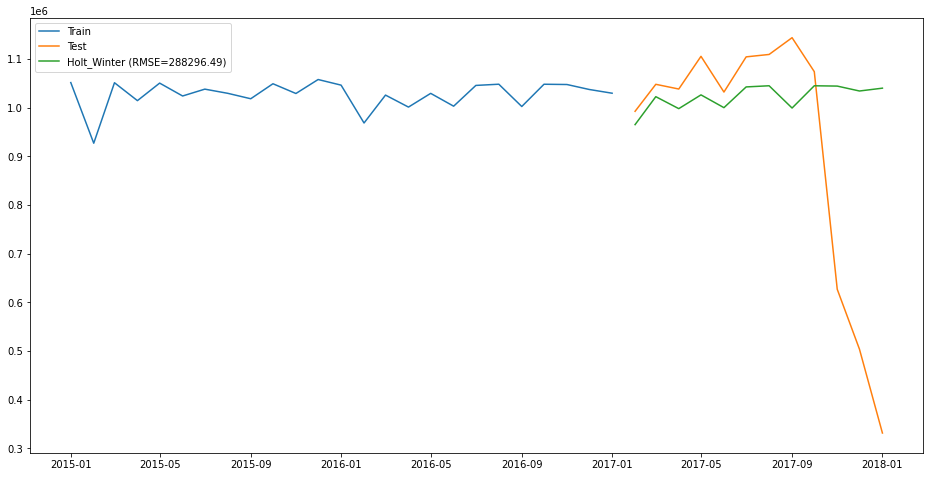

In [53]:
# Fit the model
pred = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()

pred['Holt_Winter'] = fit1.forecast(len(test))
# Calculate KPI's
mae = mean_absolute_error(test.sales, pred.Holt_Winter)
mse=mean_squared_error(test.sales, pred.Holt_Winter)
rmse = sqrt(mean_squared_error(test.sales, pred.Holt_Winter))
print("MAE {:,.2f}".format(mae))
print("MSE {:,.2f}".format(mse))
print("RMSE {:,.2f}".format(rmse))

final_result = {'Model': 'TES', 'MAE Train': mae, 'MAE Test':mae}
df_final_result=df_final_result.append(OrderedDict(final_result),ignore_index=True)

# Plot
plt.figure(figsize=(16,8))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(pred['Holt_Winter'], label='Holt_Winter (RMSE={:.2f})'.format(rmse))

plt.legend()
plt.show()

In [54]:
pred

,sales,Holt_Winter
order_month,,
2017-02-01,992534.90,965175.30
2017-03-01,1048004.78,1022598.64
2017-04-01,1038321.62,998008.84
2017-05-01,1105485.32,1026288.04
2017-06-01,1032086.49,1000036.84
2017-07-01,1104373.36,1042638.97
2017-08-01,1109337.17,1045014.51
2017-09-01,1143775.11,999275.93
2017-10-01,1073994.17,1044999.10


## <font color='BLUE'> Observations: </font>
- From all these three exponential smoothing methods we could see Triple exponential model producing good results compared to other models. 
- We have use the parameters (alpha 0.2 and beta 0.1) and observe that SES gives a straight line because it forecast the future demand as its last estimation which is not that much helpful for forecasting expected results. Although, in DES, we have seen little increasing trend but that line is also a straight and not a good predictor. Triple exponential smoothing model is providing fluctuating line for forcasting which is little similar to test data and is considering trend and seasonality thus, proved to be best among three.

# <font color='RED'> Machine Learning Models </font>

In [55]:
df_sales_orig = pd.read_csv(data_folder + 'sales_data_after_preprocessing.csv', index_col=0, parse_dates=True)
pd.options.display.float_format = '{:,.2f}'.format
print('df_sales_orig.shape:', df_sales_orig.shape)
df_sales_orig.head()

df_sales_orig.shape: (37, 1)


,sales
order_month,
2015-01-01,"1,051,590.08"
2015-02-01,"927,009.90"
2015-03-01,"1,051,253.69"
2015-04-01,"1,014,463.28"
2015-05-01,"1,050,478.44"


## Prepare the Dataset for Machine Learning

In [56]:
df=pd.DataFrame()
df_sale=pd.DataFrame()

# Create 12 months of lag values to predict current observation
# Shift of 12 months in this case
for i in range(12,0,-1):
    df[['t-'+str(i)]] = df_sales_orig.shift(i)

print(' Create 12 months of lag values to predict current observation')
print(df)
print('============================================================================')
print('Create column t')
df['t'] = df_sales_orig.values
print(df.head(14))
print('============================================================================')
print('Create a new subsetted dataframe, removing Nans from first 12 rows')
df_sale = df[12:]
print('df_sale.shape:',df_sale.shape)
print(df_sale)

 Create 12 months of lag values to predict current observation
                    t-12         t-11         t-10          t-9          t-8  \
order_month                                                                    
2015-01-01           NaN          NaN          NaN          NaN          NaN   
2015-02-01           NaN          NaN          NaN          NaN          NaN   
2015-03-01           NaN          NaN          NaN          NaN          NaN   
2015-04-01           NaN          NaN          NaN          NaN          NaN   
2015-05-01           NaN          NaN          NaN          NaN          NaN   
2015-06-01           NaN          NaN          NaN          NaN          NaN   
2015-07-01           NaN          NaN          NaN          NaN          NaN   
2015-08-01           NaN          NaN          NaN          NaN          NaN   
2015-09-01           NaN          NaN          NaN          NaN 1,051,590.08   
2015-10-01           NaN          NaN          NaN 1,051,

## Split Data into dependent(target) and independent(features) variables

In [57]:
df = df_sale.values
# Lagged variables (features) and original time series data (target)
X2= df[:,0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y2 = df[:,-1]  # slice all rows and last column, essentially separating out 't' column

# Columns t-1 to t-12, which are the lagged variables
print('X2.shape',X2.shape)

# Column t, which is the original time series
# Give first 10 values of target variable, time series
print('y2.shape',y2.shape)

X2.shape (25, 12)
y2.shape (25,)


## <font color='BLUE'> Splitting train & test 80:20 </font>

In [58]:
result_80= pd.DataFrame()

# Target(Y) Train-Test split
pct_train = 0.8

Y2 = y2
traintarget_size = int(len(Y2) * pct_train)   # Set split
print(traintarget_size)
train_target, test_target = Y2[:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observations for Target: %d' % (len(Y2)))
print('Training Observations for Target: %d' % (len(train_target)))
print('Testing Observations for Target: %d' % (len(test_target)))

# Features(X) Train-Test split

trainfeature_size = int(len(X2) * pct_train)
train_feature, test_feature = X2[:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observations for feature: %d' % (len(X2)))
print('Training Observations for feature: %d' % (len(train_feature)))
print('Testing Observations for feature: %d' % (len(test_feature)))

20
Observations for Target: 25
Training Observations for Target: 20
Testing Observations for Target: 5
Observations for feature: 25
Training Observations for feature: 20
Testing Observations for feature: 5


## Benchmark Model (Linear Regression Model)

In [59]:
from sklearn.linear_model import LinearRegression
  
reg = LinearRegression() # Create a linear regression object
  
reg = reg.fit(train_feature, train_target) # Fit it to the training data
  
# Create two predictions for the training and test sets
train_prediction = reg.predict(train_feature)
test_prediction = reg.predict(test_feature)


print('Train R-square:', reg.score(train_feature, train_target))
print('Test R-square:', reg.score(test_feature, test_target), '\n') 

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))


RsquareScoreTrain = reg.score(train_feature, train_target)
RsquareScoreTest = reg.score(test_feature, test_target)

result={'Model':'Benchmark (80|20)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_80=result_80.append(pd.DataFrame(result), ignore_index=True)

Train R-square: 0.7131013232423282
Test R-square: -0.35463702284071275 

Tree on train set MAE%: 2.1
Tree on test set MAE%: 42.0


## Decision Tree Model

In [60]:
# Decision Tree Regression Model

from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
dt_reg = DecisionTreeRegressor()  # max_depth not set

# Fit the model to the training features and targets
dt_reg.fit(train_feature, train_target)

# Check the score on train and test
print(dt_reg.score(train_feature, train_target))
print(dt_reg.score(test_feature,test_target))  # predictions are horrible if negative value, no relationship if 0


1.0
-0.9016034244692932


In [61]:
# Find Best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.

for d in [2, 3,4, 5,7,8,10]:
    # Create the tree and fit it
    dt_reg = DecisionTreeRegressor(max_depth=d)
    dt_reg.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print('Train R-square:', dt_reg.score(train_feature, train_target))
    print('Test R-square:', dt_reg.score(test_feature, test_target), '\n')  # You want the test score to be positive
    
# R-square for train and test scores are below. 

max_depth= 2
Train R-square: 0.8071127118421451
Test R-square: -1.026089090257682 

max_depth= 3
Train R-square: 0.9925893983637054
Test R-square: -1.0728602271395973 

max_depth= 4
Train R-square: 0.9998506443017383
Test R-square: -0.9118218372746334 

max_depth= 5
Train R-square: 0.9999912706162014
Test R-square: -1.035658977023937 

max_depth= 7
Train R-square: 0.9999999052405638
Test R-square: -0.9092605390082535 

max_depth= 8
Train R-square: 1.0
Test R-square: -0.8952193129091763 

max_depth= 10
Train R-square: 1.0
Test R-square: -1.0232609125120264 



**The best max_depth is max_depth that gives the best test score (positive and high).**

Tree on train set MAE%: 0.3
Tree on test set MAE%: 50.9


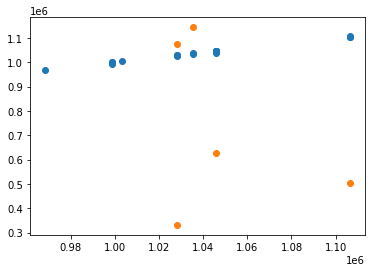

In [62]:
# Plot predicted against actual values
best_max_depth = 3

from matplotlib import pyplot as plt

# Use the best max_depth 
dt_reg = DecisionTreeRegressor(max_depth=best_max_depth) # Fill in best max depth score here
dt_reg.fit(train_feature, train_target)

# Predict values for train and test
train_prediction = dt_reg.predict(train_feature)

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))


test_prediction = dt_reg.predict(test_feature)
MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))


RsquareScoreTrain = dt_reg.score(train_feature, train_target)
RsquareScoreTest = dt_reg.score(test_feature, test_target)
result={'Model':'Decision Tree (80|20)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_80=result_80.append(pd.DataFrame(result), ignore_index=True)



# Scatter the predictions vs actual values, orange is predicted
plt.scatter(train_prediction, train_target, label='train')  # blue 
plt.scatter(test_prediction, test_target, label='test')  
plt.show()

### Random Forest Model

In [63]:
# Random Forest Model
print('==========================================================================================')
print('RANDOM FOREST MODEL')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np

# Create the random forest model and fit to the training data
rfr_reg = RandomForestRegressor(n_estimators=200)
rfr_reg.fit(train_feature, train_target)

# Look at the R^2 scores on train and test
print('Train R-square:', rfr_reg.score(train_feature, train_target))
print('Test R-square:', rfr_reg.score(test_feature, test_target))  # Try to attain a positive value

RANDOM FOREST MODEL
Train R-square: 0.8739630134243286
Test R-square: -0.9642082203552249


In [64]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Create a dictionary of hyperparameters to search
# n_estimators is the number of trees in the forest. The larger the better, but also takes longer it will take to compute. 
# Run grid search
#grid = {'n_estimators': [20,30,50,100,150,200], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'random_state': [11,22]}


grid = {'n_estimators': [10,30,70,90], 'max_depth': [5], 'max_features': [9], 'random_state': [11]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr_reg.set_params(**g)  # ** is "unpacking" the dictionary
    rfr_reg.fit(train_feature, train_target)
    test_scores.append(rfr_reg.score(test_feature, test_target))
    print('grid:',g, ' Score:', rfr_reg.score(test_feature, test_target))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print('The best hyperparameter:', test_scores[best_idx], ParameterGrid(grid)[best_idx])  
# The best hyperparameter: 0.73407562486015 {'random_state': 523, 'n_estimators': 20, 'max_features': 10, 'max_depth': 6}
# The best hyperparameter: 0.7383598563923621 {'random_state': 11, 'n_estimators': 30, 'max_features': 9, 'max_depth': 5}

grid: {'max_depth': 5, 'max_features': 9, 'n_estimators': 10, 'random_state': 11}  Score: -1.046120725319923
grid: {'max_depth': 5, 'max_features': 9, 'n_estimators': 30, 'random_state': 11}  Score: -0.971135515637201
grid: {'max_depth': 5, 'max_features': 9, 'n_estimators': 70, 'random_state': 11}  Score: -0.9640843601191758
grid: {'max_depth': 5, 'max_features': 9, 'n_estimators': 90, 'random_state': 11}  Score: -0.956470991259859
The best hyperparameter: -0.956470991259859 {'random_state': 11, 'n_estimators': 90, 'max_features': 9, 'max_depth': 5}


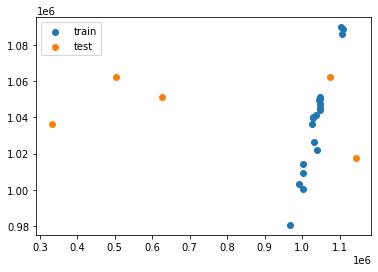

Tree on train set MAE%: 1.2
Tree on test set MAE%: 49.6


In [65]:
# Use the best hyperparameters from before to fit a random forest model
rfr_reg = RandomForestRegressor(n_estimators=30, max_depth=5, max_features = 9, random_state=11)
rfr_reg.fit(train_feature, train_target)

# Make predictions with our model
train_prediction = rfr_reg.predict(train_feature)
test_prediction = rfr_reg.predict(test_feature)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_target, train_prediction, label='train')
plt.scatter(test_target, test_prediction, label='test')
plt.legend()
plt.show()

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))

RsquareScoreTrain = rfr_reg.score(train_feature, train_target)
RsquareScoreTest = rfr_reg.score(test_feature, test_target)
result={'Model':'Random Forest (80|20)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_80=result_80.append(pd.DataFrame(result), ignore_index=True)


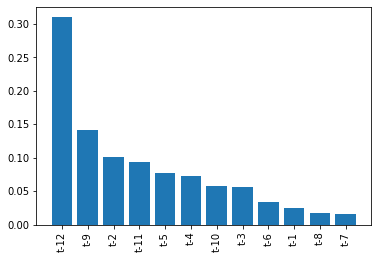

In [66]:
# Get feature importances from our random forest model
importances = rfr_reg.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3','t-2', 't-1']
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## Gradient Boosted Tree Model

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

# Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
# Create GB model -- hyperparameters 
gbr = GradientBoostingRegressor(max_features=9,
                                learning_rate=0.07,
                                n_estimators=100,
                                subsample=0.6,
                                random_state=33)

gbr.fit(train_feature, train_target)

print(gbr.score(train_feature, train_target))
print(gbr.score(test_feature, test_target))

0.9976972410973161
-0.9340568116851471


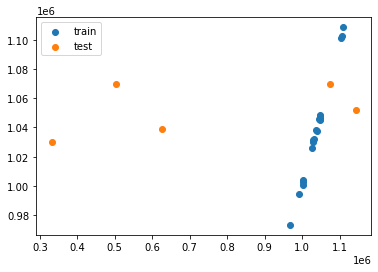

Tree on train set MAE%: 0.2
Tree on test set MAE%: 48.1


In [68]:
# Make predictions with our model
train_prediction = gbr.predict(train_feature)
test_prediction = gbr.predict(test_feature)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_target, train_prediction, label='train')
plt.scatter(test_target, test_prediction, label='test')
plt.legend()
plt.show()

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))

RsquareScoreTrain = gbr.score(train_feature, train_target)
RsquareScoreTest = gbr.score(test_feature, test_target)
result={'Model':'Gradient Boosted Tree (80|20)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_80=result_80.append(pd.DataFrame(result), ignore_index=True)

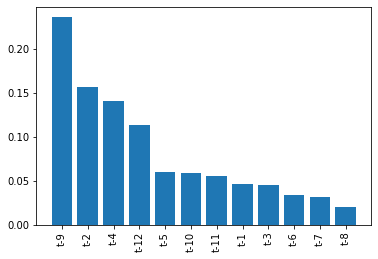

In [69]:
# Gradient Boosted Model Feature Importance
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x2 = range(X2.shape[1])

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']
labels = np.array(feature_names)[sorted_index]

plt.bar(x2, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## <font color='BLUE'> Splitting train & test 65:35 </font>

In [70]:
result_65=pd.DataFrame()

# Target(Y) Train-Test split
pct_train = 0.65

Y2 = y2
traintarget_size = int(len(Y2) * pct_train)   # Set split
print(traintarget_size)
train_target, test_target = Y2[:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observations for Target: %d' % (len(Y2)))
print('Training Observations for Target: %d' % (len(train_target)))
print('Testing Observations for Target: %d' % (len(test_target)))

# Features(X) Train-Test split

trainfeature_size = int(len(X2) * pct_train)
train_feature, test_feature = X2[:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observations for feature: %d' % (len(X2)))
print('Training Observations for feature: %d' % (len(train_feature)))
print('Testing Observations for feature: %d' % (len(test_feature)))

16
Observations for Target: 25
Training Observations for Target: 16
Testing Observations for Target: 9
Observations for feature: 25
Training Observations for feature: 16
Testing Observations for feature: 9


## Benchmark Model (Linear Regression Model)

In [71]:
from sklearn.linear_model import LinearRegression
  
reg = LinearRegression() # Create a linear regression object
  
reg = reg.fit(train_feature, train_target) # Fit it to the training data
  
# Create two predictions for the training and test sets
train_prediction = reg.predict(train_feature)
test_prediction = reg.predict(test_feature)

print('Train R-square:', reg.score(train_feature, train_target))
print('Test R-square:', reg.score(test_feature, test_target), '\n') 

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))

RsquareScoreTrain = reg.score(train_feature, train_target)
RsquareScoreTest = reg.score(test_feature, test_target)
result={'Model':'BenchMark - Linear Regression (65|35)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_65=result_65.append(pd.DataFrame(result), ignore_index=True)

Train R-square: 0.804923906577958
Test R-square: -0.8840475491911497 

Tree on train set MAE%: 0.9
Tree on test set MAE%: 33.1


## Decision Tree Model

In [72]:
# Decision Tree Regression Model

from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
dt_reg = DecisionTreeRegressor()  # max_depth not set

# Fit the model to the training features and targets
dt_reg.fit(train_feature, train_target)

# Check the score on train and test
print('Train RSquare:', dt_reg.score(train_feature, train_target))
print('Test RSquare:', dt_reg.score(test_feature,test_target))  # predictions are horrible if negative value, no relationship if 0

Train RSquare: 1.0
Test RSquare: -0.22588164461598925


In [73]:
# Find Best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.

for d in [2, 3,4, 5,7,8,10]:
    # Create the tree and fit it
    dt_reg = DecisionTreeRegressor(max_depth=d)
    dt_reg.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print('Train R-square:', dt_reg.score(train_feature, train_target))
    print('Test R-square:', dt_reg.score(test_feature, test_target), '\n')  # You want the test score to be positive
    
# R-square for train and test scores are below.

max_depth= 2
Train R-square: 0.8959769720024339
Test R-square: -0.2333657052890925 

max_depth= 3
Train R-square: 0.991510604122441
Test R-square: -0.21469809142634988 

max_depth= 4
Train R-square: 0.9997650047601905
Test R-square: -0.2250716698952855 

max_depth= 5
Train R-square: 0.9999738974378853
Test R-square: -0.2349257896917647 

max_depth= 7
Train R-square: 1.0
Test R-square: -0.2464668227221345 

max_depth= 8
Train R-square: 1.0
Test R-square: -0.24595327612754336 

max_depth= 10
Train R-square: 1.0
Test R-square: -0.2321440265392698 



Tree on train set MAE%: 0.5
Tree on test set MAE%: 25.6


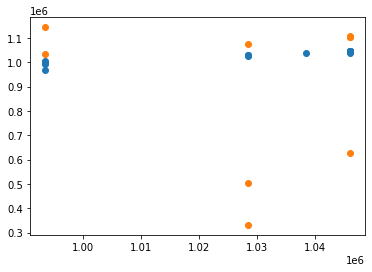

In [74]:
# Plot predicted against actual values
best_max_depth = 2

from matplotlib import pyplot as plt

# Use the best max_depth 
dt_reg = DecisionTreeRegressor(max_depth=best_max_depth) # Fill in best max depth score here
dt_reg.fit(train_feature, train_target)

# Predict values for train and test
train_prediction = dt_reg.predict(train_feature)

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))


test_prediction = dt_reg.predict(test_feature)

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))


RsquareScoreTrain = dt_reg.score(train_feature, train_target)
RsquareScoreTest = dt_reg.score(test_feature, test_target)
result={'Model':'Decision Tree (65|35)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_65=result_65.append(pd.DataFrame(result), ignore_index=True)


# Scatter the predictions vs actual values, orange is predicted
plt.scatter(train_prediction, train_target, label='train')  # blue 
plt.scatter(test_prediction, test_target, label='test')  
plt.show()

## Random Forest Model

In [75]:
# Random Forest Model
print('==========================================================================================')
print('RANDOM FOREST MODEL')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np

# Create the random forest model and fit to the training data
rfr_reg = RandomForestRegressor(n_estimators=200)
rfr_reg.fit(train_feature, train_target)

# Look at the R^2 scores on train and test
print('Train R-square:', rfr_reg.score(train_feature, train_target))
print('Test R-square:', rfr_reg.score(test_feature, test_target))  # Try to attain a positive value

RANDOM FOREST MODEL
Train R-square: 0.8760517417267749
Test R-square: -0.20116097202243588


In [76]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Create a dictionary of hyperparameters to search
# n_estimators is the number of trees in the forest. The larger the better, but also takes longer it will take to compute. 
# Run grid search
#grid = {'n_estimators': [20,30,50,100,150,200], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'random_state': [11,22]}


grid = {'n_estimators': [20,30], 'max_depth': [5], 'max_features': [6], 'random_state': [11]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr_reg.set_params(**g)  # ** is "unpacking" the dictionary
    rfr_reg.fit(train_feature, train_target)
    test_scores.append(rfr_reg.score(test_feature, test_target))
    print('grid:',g, ' Score:', rfr_reg.score(test_feature, test_target))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print('The best hyperparameter:', test_scores[best_idx], ParameterGrid(grid)[best_idx])  
# The best hyperparameter: 0.7745605248416195 {'random_state': 11, 'n_estimators': 20, 'max_features': 6, 'max_depth': 5}

grid: {'max_depth': 5, 'max_features': 6, 'n_estimators': 20, 'random_state': 11}  Score: -0.1752773899979687
grid: {'max_depth': 5, 'max_features': 6, 'n_estimators': 30, 'random_state': 11}  Score: -0.18220917290580885
The best hyperparameter: -0.1752773899979687 {'random_state': 11, 'n_estimators': 20, 'max_features': 6, 'max_depth': 5}


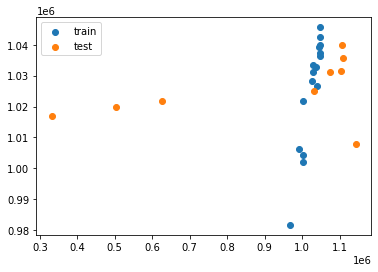

Tree on train set MAE%: 0.8
Tree on test set MAE%: 24.8


In [77]:
# Use the best hyperparameters from before to fit a random forest model
rfr_reg = RandomForestRegressor(n_estimators=20, max_depth=5, max_features =6, random_state=11)
rfr_reg.fit(train_feature, train_target)

# Make predictions with our model
train_prediction = rfr_reg.predict(train_feature)
test_prediction = rfr_reg.predict(test_feature)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_target, train_prediction, label='train')
plt.scatter(test_target, test_prediction, label='test')
plt.legend()
plt.show()

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))

RsquareScoreTrain = rfr_reg.score(train_feature, train_target)
RsquareScoreTest = rfr_reg.score(test_feature, test_target)
result={'Model':'Random Forest (65|35)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_65=result_65.append(pd.DataFrame(result), ignore_index=True)


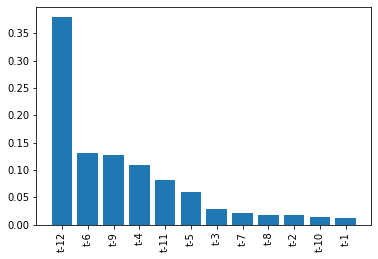

In [78]:
# Get feature importances from our random forest model
importances = rfr_reg.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3','t-2', 't-1']
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## Gradient Boosted Tree Model

In [79]:
from sklearn.ensemble import GradientBoostingRegressor

# Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
# Create GB model -- hyperparameters 
gbr = GradientBoostingRegressor(max_features=3,
                                learning_rate=0.09,
                                n_estimators=100,
                                subsample=0.6,
                                random_state=22)

gbr.fit(train_feature, train_target)

print(gbr.score(train_feature, train_target))
print(gbr.score(test_feature, test_target))

0.9994242502272846
-0.18357383481891265


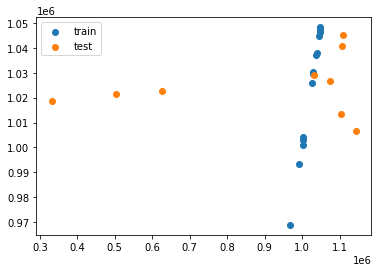

Tree on train set MAE%: 0.1
Tree on test set MAE%: 25.0


In [80]:
# Make predictions with our model
train_prediction = gbr.predict(train_feature)
test_prediction = gbr.predict(test_feature)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_target, train_prediction, label='train')
plt.scatter(test_target, test_prediction, label='test')
plt.legend()
plt.show()

# Compute the MAE for both the training and test sets

MAE_train=np.mean(abs(train_target-train_prediction))/np.mean(test_target)
print("Tree on train set MAE%:", round(MAE_train*100,1))

MAE_test=np.mean(abs(test_target-test_prediction))/np.mean(test_target)
print("Tree on test set MAE%:", round(MAE_test*100,1))

RsquareScoreTrain = gbr.score(train_feature, train_target)
RsquareScoreTest = gbr.score(test_feature, test_target)
result={'Model':'Gradient Boosted Tree (65|35)','Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
result_65=result_65.append(pd.DataFrame(result), ignore_index=True)



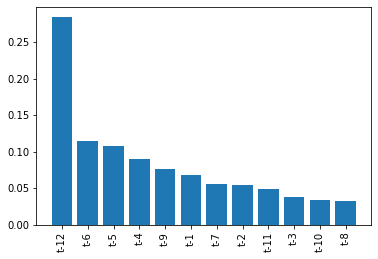

In [81]:
# Gradient Boosted Model Feature Importance
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x2 = range(X2.shape[1])

# Create tick labels 
feature_names = ['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']
labels = np.array(feature_names)[sorted_index]

plt.bar(x2, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## <font color='BLUE'> ML Models results </font>

In [82]:
result_80.sort_values(by=['Rsquare Train','R-square Test'], ascending=False)

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test
3,Gradient Boosted Tree (80|20),1.00,-0.93,0.20,48.10
1,Decision Tree (80|20),0.99,-1.04,0.30,50.90
2,Random Forest (80|20),0.92,-0.97,1.20,49.60
0,Benchmark (80|20),0.71,-0.35,2.10,42.00


In [83]:
result_65.sort_values(by=['Rsquare Train','R-square Test'], ascending=False)

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test
3,Gradient Boosted Tree (65|35),1.00,-0.18,0.10,25.00
1,Decision Tree (65|35),0.90,-0.23,0.50,25.60
2,Random Forest (65|35),0.86,-0.18,0.80,24.80
0,BenchMark - Linear Regression (65|35),0.80,-0.88,0.90,33.10


# <font color='RED'> Final Conclusion </font>

In [84]:
df_ml_result =[]
df_ml_result = result_80.append(result_65)
df_ml_result= df_ml_result.sort_values(by=['MAE Test'], ascending=True).reset_index()

final_result = {'Model': df_ml_result.iloc[0]['Model'], 'MAE Train': df_ml_result.iloc[0]['MAE Train'] , 'MAE Test':df_ml_result.iloc[0]['MAE Test']}
df_final_result = df_final_result.append(OrderedDict(final_result),ignore_index=True)

df_final_result=df_final_result.sort_values(by=['MAE Test'], ascending=True)
df_final_result

,MAE Test,MAE Train,Model
0,0.15,0.02,LSTM
5,24.80,0.80,Random Forest (65|35)
1,"62,513.00","62,513.00",MA
2,"172,590.86","172,590.86",SES
3,"173,160.57","173,160.57",DES
4,"180,007.27","180,007.27",TES


#### - MAE of LSTM model is the smallest that are 0.02 for training phase and 0.15 for test phase within sample. However, the forecast for next 12-months period shows the line without fluctuation and trend.  
#### - MA and Exponential Smoothing Models are not well fit due to very large MAE.  

#### - In this project, we practiced again all learnt time-series methods for sales forecast that is a small part of supply chain analytics. The best model is good for train and test phases within sample data. However, we cannot evaluate for out-of-sample case. Therefore, more training data is expected so that the model can learn more the trend and seasonal feature in time-series data and do forecasting better.  
